# Visão Computacional - Tech Challenge 5  
## Pós-Tech em Inteligência Artificial - FIAP  
### Augusto Vieira Favi  

---

### Introdução  

Neste projeto, explorarei o uso de Inteligência Artificial para aumentar a segurança em estabelecimentos e comércios, implementando uma funcionalidade em monitoramento de câmeras de segurança. A proposta visa detectar objetos cortantes (como facas e tesouras) em tempo real, emitindo alertas preventivos para situações potencialmente perigosas.  

O projeto é estruturado em quatro objetivos principais:  

1. **Utilização de Dataset do Kaggle**: Para o treinamento do modelo, estou utilizando um dataset disponível no Kaggle, chamado ["Knife Dataset"](https://www.kaggle.com/datasets/shank885/knife-dataset). Esse dataset contém imagens de objetos cortantes em diversas condições de ângulo e iluminação, incluindo imagens negativas (sem objetos perigosos) para minimizar falsos positivos.  

2. **Treinamento do Modelo**: Utilizar algoritmos de aprendizado supervisionado para treinar o modelo de detecção de objetos cortantes com alta precisão.  

3. **Desenvolvimento de Sistema de Alertas**: Implementar um sistema de notificação em tempo real, como o envio de alertas por e-mail para a central de segurança.  

4. **Validação e Testes**: Validar o modelo utilizando vídeos de teste fornecidos, garantindo a eficácia da detecção em cenários reais. \

## **Imports**

In [1]:
import os
import cv2
import shutil
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from datetime import datetime

# Verify dataset structure
dataset_path = './datasets/knife-dataset'

## *DATASET UTILIZADO*
Dataset de uma comunidade no Roboflow:
<br>
https://universe.roboflow.com/workspace-zqssx/knife-dataset-new/dataset/1


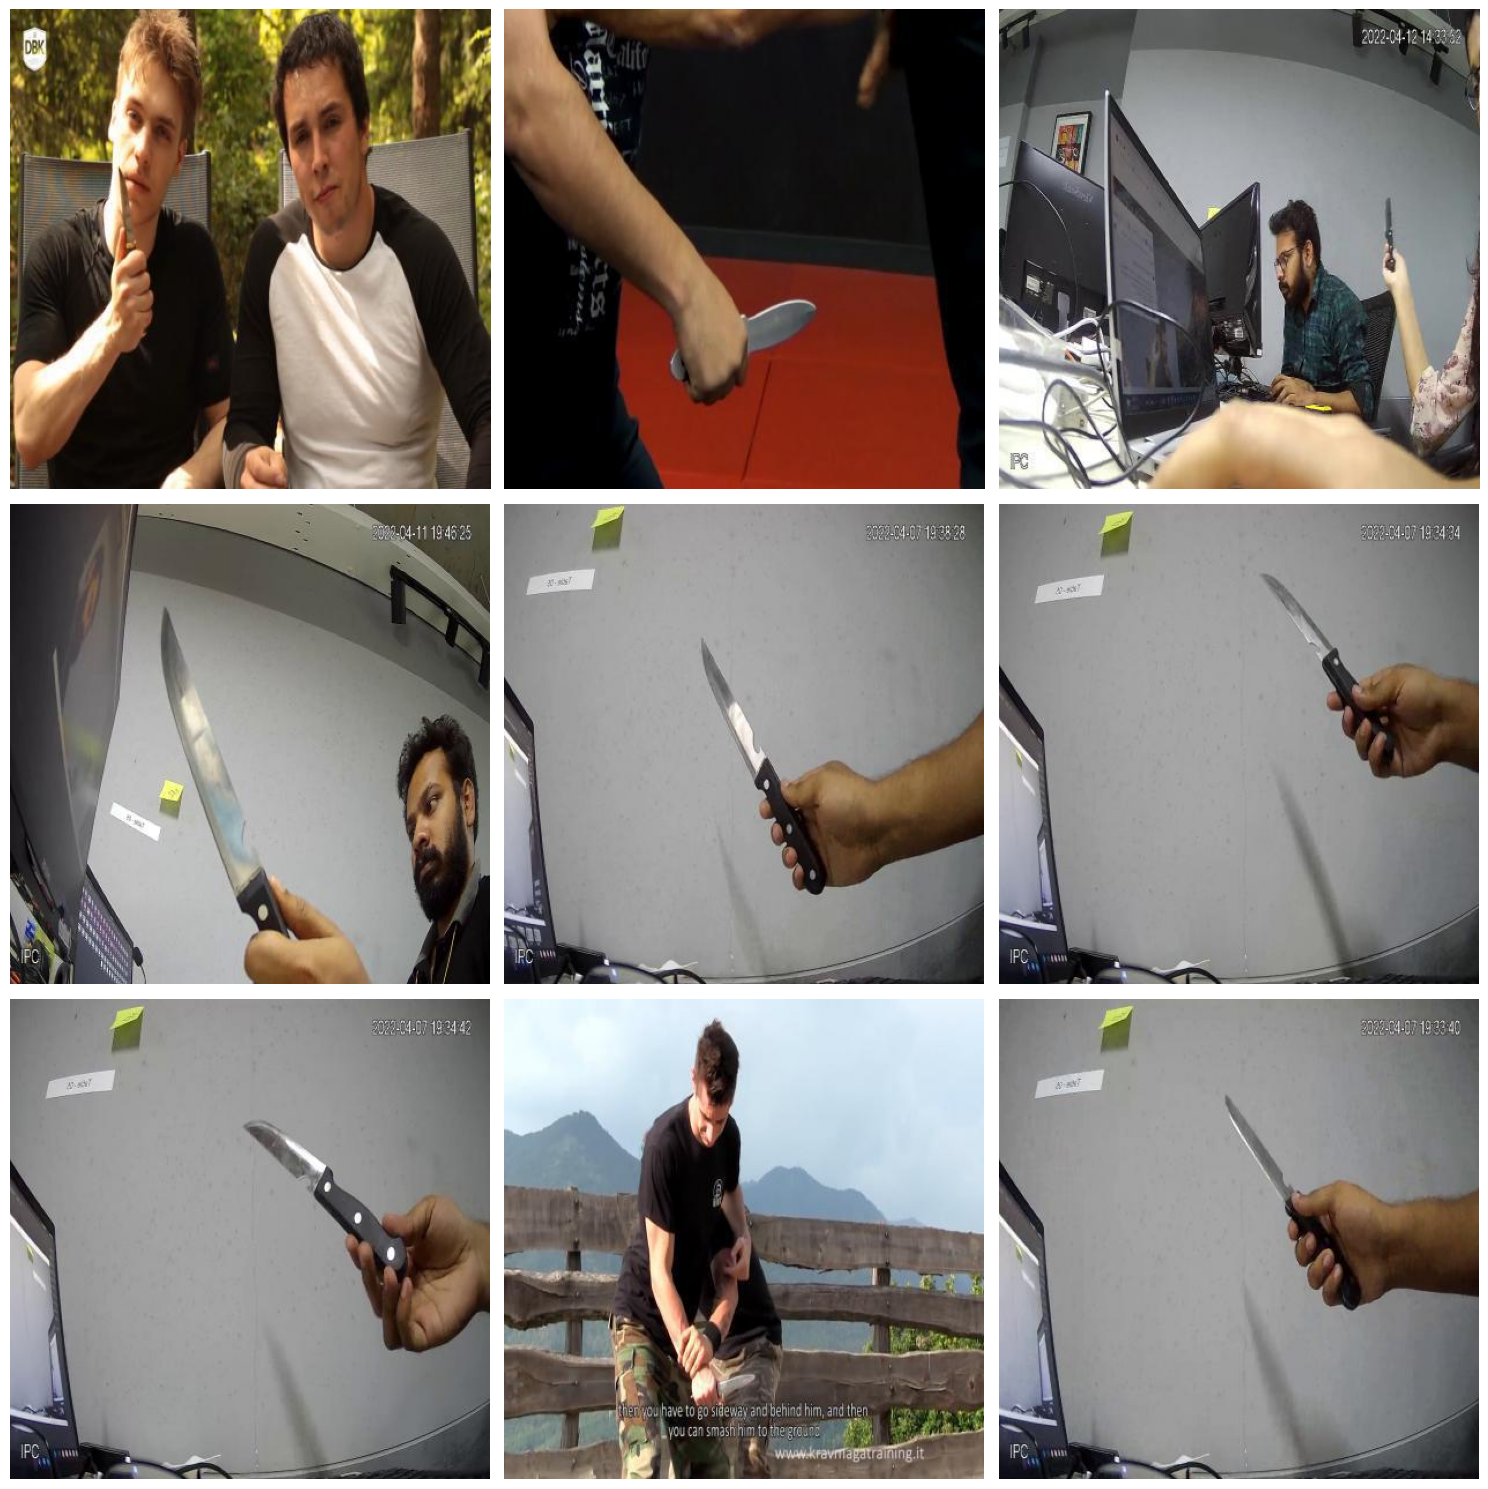

In [2]:
plt.figure(figsize=(15, 15))
image_dir = os.path.join(dataset_path, 'train', 'images')
images = [os.path.join(image_dir, f) for f in os.listdir(image_dir)[:9]]

for i, img_path in enumerate(images):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

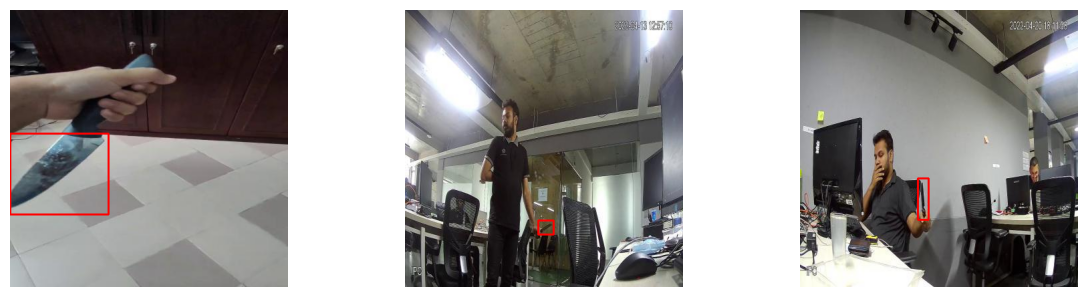

In [3]:
#Plotando com as Labels de treino
img_dir = os.path.join(dataset_path, 'train', 'images')
label_dir = os.path.join(dataset_path, 'train', 'labels')

plt.figure(figsize=(12, 6))
for i in range(3):
    img_file = np.random.choice(os.listdir(img_dir))
    img_path = os.path.join(img_dir, img_file)
    label_path = os.path.join(label_dir, img_file.replace('.jpg', '.txt'))
    
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            boxes = [list(map(float, line.split())) for line in f.readlines()]
        
        for box in boxes:
            _, x_center, y_center, width, height = box
            x1 = int((x_center - width/2) * w)
            y1 = int((y_center - height/2) * h)
            x2 = int((x_center + width/2) * w)
            y2 = int((y_center + height/2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Treinamento do Modelo

**Modelo Escolhido:**
YOLOv8 Nano

Com parametros padrão


In [4]:
def save_best_model(experiment_dir='runs/detect/visionguard_v1'):
    # Find best model
    weights_dir = Path(experiment_dir) / 'weights'
    best_model_path = weights_dir / 'best.pt'
    
    # Create models directory
    model_dir = Path('saved_models')
    model_dir.mkdir(exist_ok=True)
    
    # Save copy with timestamp
    save_path = model_dir / f'visionguard-best-{datetime.now().strftime("%Y%m%d-%H%M")}.pt'
    shutil.copy(best_model_path, save_path)
    
    # Also export to ONNX for production
    model = YOLO(best_model_path)
    model.export(format='onnx', imgsz=640)
    
    print(f"✅ Best model saved to: {save_path}")
    return save_path

In [5]:
def train_and_save():
    model = YOLO('yolov8n.pt')
    
    results = model.train(
        data='datasets/knife-dataset.yaml',
        epochs=50,
        imgsz=640,
        batch=16,
        name='visionguard_v1',
        save=True,  # Ensure saving is enabled
        save_period=10,  # Save checkpoint every 10 epochs
    )
    
    # Save best version
    return save_best_model()

# Run training and saving
best_model_path = train_and_save()

Ultralytics 8.3.76 🚀 Python-3.9.21 torch-2.6.0 CPU (Apple M1 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets/knife-dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=None, workers=8, project=None, name=visionguard_v14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

train: Scanning /Users/augusto.favi/Desktop/Tech Challenge 5/datasets/knife-dataset/train/labels.cache... 2893 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2893/2893 [00:00<?, ?it/s]
val: Scanning /Users/augusto.favi/Desktop/Tech Challenge 5/datasets/knife-dataset/valid/labels.cache... 797 images, 0 backgrounds, 0 corrupt: 100%|██████████| 797/797 [00:00<?, ?it/s]


Plotting labels to runs/detect/visionguard_v14/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/visionguard_v14
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.864      2.858      1.737         18        640: 100%|██████████| 181/181 [17:48<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:12<00:00,  5.30s/it]

                   all        797        849      0.308      0.273      0.218     0.0886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      2.011      2.516      1.899         22        640: 100%|██████████| 181/181 [18:16<00:00,  6.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:12<00:00,  5.32s/it]

                   all        797        849      0.351      0.225      0.182     0.0618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G       2.05      2.373      1.937         24        640: 100%|██████████| 181/181 [18:06<00:00,  6.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:10<00:00,  5.24s/it]

                   all        797        849      0.355      0.319       0.22      0.077



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      2.013       2.23      1.887         23        640: 100%|██████████| 181/181 [18:32<00:00,  6.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:14<00:00,  5.36s/it]

                   all        797        849      0.456      0.405      0.353      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G       1.93      2.076      1.844         20        640: 100%|██████████| 181/181 [18:45<00:00,  6.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:11<00:00,  5.25s/it]

                   all        797        849      0.548      0.527      0.525      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.904       1.98      1.803         22        640: 100%|██████████| 181/181 [18:18<00:00,  6.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:12<00:00,  5.31s/it]

                   all        797        849      0.594      0.527      0.557      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.847      1.911      1.785         16        640: 100%|██████████| 181/181 [17:54<00:00,  5.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:10<00:00,  5.22s/it]

                   all        797        849      0.586      0.459      0.485      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.809      1.802      1.729         27        640: 100%|██████████| 181/181 [17:51<00:00,  5.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:10<00:00,  5.24s/it]

                   all        797        849      0.617      0.569      0.606       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.787      1.754      1.704         11        640: 100%|██████████| 181/181 [17:48<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:10<00:00,  5.23s/it]

                   all        797        849      0.681       0.63      0.656      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.743      1.668      1.674         25        640: 100%|██████████| 181/181 [18:25<00:00,  6.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:13<00:00,  5.34s/it]

                   all        797        849      0.711       0.64      0.693      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.708      1.611      1.643         29        640: 100%|██████████| 181/181 [18:57<00:00,  6.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:12<00:00,  5.31s/it]

                   all        797        849      0.781      0.625      0.729      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G       1.68      1.571      1.637         25        640: 100%|██████████| 181/181 [19:04<00:00,  6.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:13<00:00,  5.35s/it]

                   all        797        849      0.752      0.625       0.71      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.657      1.515      1.609         26        640: 100%|██████████| 181/181 [18:23<00:00,  6.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:11<00:00,  5.25s/it]

                   all        797        849      0.787        0.7       0.78      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.644      1.484      1.589         25        640: 100%|██████████| 181/181 [17:43<00:00,  5.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:10<00:00,  5.22s/it]

                   all        797        849      0.753       0.64      0.708      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G       1.61      1.421      1.576         15        640: 100%|██████████| 181/181 [17:50<00:00,  5.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:11<00:00,  5.27s/it]

                   all        797        849      0.785      0.676      0.784      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.615      1.394      1.572         19        640: 100%|██████████| 181/181 [17:54<00:00,  5.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:11<00:00,  5.26s/it]

                   all        797        849      0.763      0.687      0.755      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.597      1.384      1.568         21        640: 100%|██████████| 181/181 [18:43<00:00,  6.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:13<00:00,  5.32s/it]

                   all        797        849      0.854      0.718      0.809      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G       1.56      1.326      1.532         27        640: 100%|██████████| 181/181 [18:55<00:00,  6.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:12<00:00,  5.29s/it]

                   all        797        849      0.836      0.706      0.799      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.559      1.308      1.531         22        640: 100%|██████████| 181/181 [18:49<00:00,  6.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:13<00:00,  5.33s/it]

                   all        797        849      0.847      0.726       0.82      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.545      1.282       1.51         26        640: 100%|██████████| 181/181 [17:45<00:00,  5.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:10<00:00,  5.21s/it]

                   all        797        849      0.822      0.759      0.836      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.543      1.245      1.511         17        640: 100%|██████████| 181/181 [17:47<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:10<00:00,  5.23s/it]

                   all        797        849      0.749      0.701      0.757      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.533      1.276      1.522         24        640: 100%|██████████| 181/181 [17:50<00:00,  5.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:12<00:00,  5.31s/it]

                   all        797        849      0.831      0.743      0.828      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.517      1.218      1.494         31        640: 100%|██████████| 181/181 [17:46<00:00,  5.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:11<00:00,  5.25s/it]

                   all        797        849      0.869      0.744       0.86      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.489      1.193      1.479         25        640: 100%|██████████| 181/181 [17:52<00:00,  5.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:10<00:00,  5.23s/it]

                   all        797        849      0.869      0.783      0.864      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.492      1.173      1.464         18        640: 100%|██████████| 181/181 [17:55<00:00,  5.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:11<00:00,  5.24s/it]

                   all        797        849      0.816      0.789       0.85      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.471      1.157      1.444         27        640: 100%|██████████| 181/181 [17:41<00:00,  5.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:10<00:00,  5.22s/it]

                   all        797        849      0.855      0.801      0.887       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.444      1.146      1.437         14        640: 100%|██████████| 181/181 [18:30<00:00,  6.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:11<00:00,  5.25s/it]

                   all        797        849      0.878      0.786      0.881      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.433      1.111      1.438         23        640: 100%|██████████| 181/181 [18:22<00:00,  6.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:11<00:00,  5.25s/it]

                   all        797        849      0.877      0.775      0.874      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.435      1.108      1.433         20        640: 100%|██████████| 181/181 [18:01<00:00,  5.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:10<00:00,  5.22s/it]

                   all        797        849       0.86      0.791      0.869      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G       1.43      1.086      1.435         27        640: 100%|██████████| 181/181 [18:45<00:00,  6.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:10<00:00,  5.23s/it]

                   all        797        849       0.88       0.81      0.891      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.399      1.044      1.405         20        640: 100%|██████████| 181/181 [18:34<00:00,  6.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:12<00:00,  5.31s/it]

                   all        797        849      0.878      0.825      0.897      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.389      1.043      1.409         23        640: 100%|██████████| 181/181 [17:56<00:00,  5.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [02:10<00:00,  5.23s/it]

                   all        797        849      0.899      0.824      0.898      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.386      1.031      1.401         19        640:  87%|████████▋ | 157/181 [16:29<02:31,  6.30s/it]


KeyboardInterrupt: 

In [7]:


# For last checkpoint
model = YOLO('runs/detect/visionguard_v14/weights/last.pt')

# For best checkpoint so far
model = YOLO('runs/detect/visionguard_v14/weights/best.pt')

In [8]:
metrics = model.val()
print(f"Validation Results:\n"
      f"mAP50-95: {metrics.box.map:.2f}\n"
      f"Precision: {metrics.box.map50:.2f}\n"
      f"Recall: {metrics.box.map75:.2f}")

Ultralytics 8.3.76 🚀 Python-3.9.21 torch-2.6.0 CPU (Apple M1 Pro)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/augusto.favi/Desktop/Tech Challenge 5/datasets/knife-dataset/valid/labels.cache... 797 images, 0 backgrounds, 0 corrupt: 100%|██████████| 797/797 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:29<00:00,  2.99s/it]


                   all        797        849      0.898      0.823      0.898      0.508
Speed: 0.6ms preprocess, 183.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val
Validation Results:
mAP50-95: 0.51
Precision: 0.90
Recall: 0.51



image 1/1 /Users/augusto.favi/Desktop/Tech Challenge 5/datasets/knife-dataset/valid/images/179_jpg.rf.c49b07de3ab4641a0eb13aa9834520d0.jpg: 640x640 1 knife, 88.5ms
Speed: 2.5ms preprocess, 88.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/augusto.favi/Desktop/Tech Challenge 5/datasets/knife-dataset/valid/images/knife_1287_jpg.rf.f034917453ce10f86b14cd1b4d2b7785.jpg: 640x640 1 knife, 68.1ms
Speed: 3.9ms preprocess, 68.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/augusto.favi/Desktop/Tech Challenge 5/datasets/knife-dataset/valid/images/15_jpg.rf.7b10e6ffb388bd2a7c2e2c2c4855bc25.jpg: 640x640 (no detections), 91.9ms
Speed: 1.9ms preprocess, 91.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


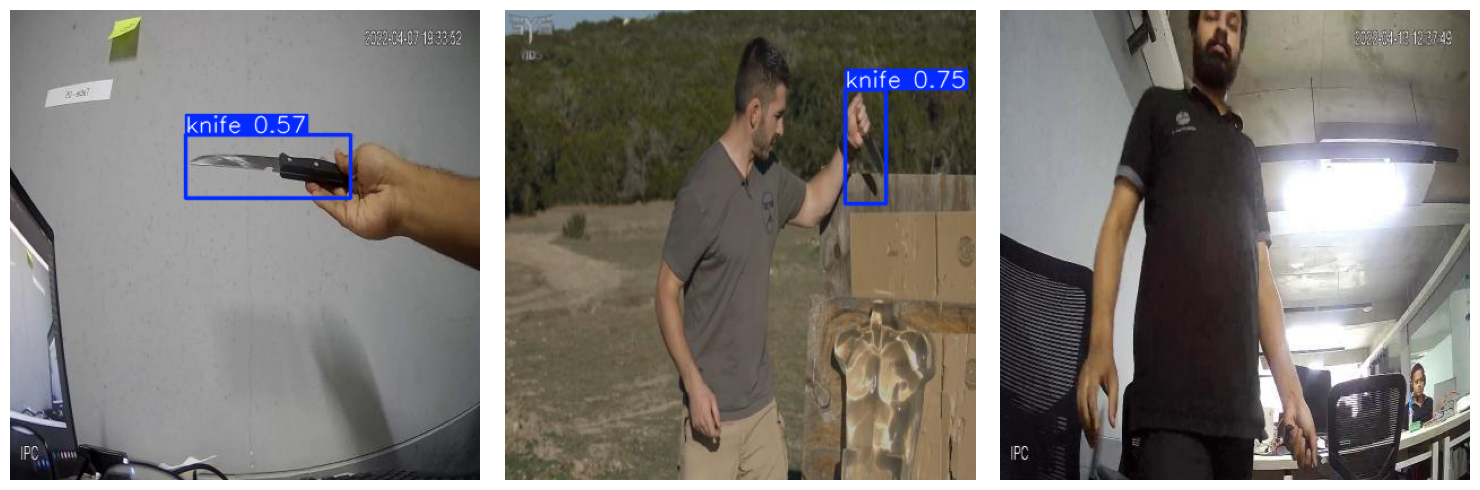

In [9]:
def show_predictions(model, dataset_path, split='valid'):
    img_dir = os.path.join(dataset_path, split, 'images')
    plt.figure(figsize=(15, 5))
    
    for i in range(3):
        img_path = os.path.join(img_dir, np.random.choice(os.listdir(img_dir)))
        results = model.predict(img_path, conf=0.5)
        annotated_img = results[0].plot()
        annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, 3, i+1)
        plt.imshow(annotated_img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(model, dataset_path)

In [ ]:
def live_detection(model, conf_threshold=0.5):
    cap = cv2.VideoCapture(0)
    
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
            
        # Perform detection
        results = model.predict(frame, conf=conf_threshold, verbose=False)
        annotated_frame = results[0].plot()
        
        # Add alert overlay if detected
        if len(results[0].boxes) > 0:
            cv2.putText(annotated_frame, "ALERTA! FACA DETECTADA", 
                       (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                       (0, 0, 255), 2, cv2.LINE_AA)
            annotated_frame = cv2.addWeighted(
                annotated_frame, 1.2, 
                np.zeros_like(annotated_frame), 0, 0
            )
            
        cv2.imshow('VisionGuard Detecção', annotated_frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()


live_detection(model)

Starting webcam... Show a sharp object to test detection!


KeyboardInterrupt: 